# Lấy dữ liệu thời tiết từ meteostat và làm sạch

### Lấy dữ liệu xuống

In [ ]:
pip install meteostat


In [ ]:
from meteostat import Point, Hourly
import datetime

location = Point(21.0245, 105.8412)
start = datetime.datetime(2024, 1, 1)
end = datetime.datetime(2025, 4, 1)

data_hourly = Hourly(location, start, end)
data_hourly = data_hourly.fetch()

print(data_hourly.head())
data_hourly.to_csv('HoGuom.csv')


                     temp  dwpt  rhum  prcp  snow   wdir  wspd  wpgt    pres  \
time                                                                           
2024-01-01 00:00:00  19.0  16.6  88.0   0.0  <NA>   70.0   5.4  <NA>  1018.0   
2024-01-01 01:00:00  21.0  17.6  83.0   0.0  <NA>   70.0   5.4  <NA>  1019.0   
2024-01-01 02:00:00  23.0  16.8  69.0   0.0  <NA>  130.0   7.6  <NA>  1019.0   
2024-01-01 03:00:00  24.0  17.0  65.0   0.0  <NA>  100.0   7.6  <NA>  1019.0   
2024-01-01 04:00:00  25.0  17.2  61.0   0.0  <NA>  120.0  11.2  <NA>  1018.0   

                     tsun  coco  
time                             
2024-01-01 00:00:00  <NA>   5.0  
2024-01-01 01:00:00  <NA>   5.0  
2024-01-01 02:00:00  <NA>   5.0  
2024-01-01 03:00:00  <NA>   2.0  
2024-01-01 04:00:00  <NA>   2.0  


### Tiền xử lý dữ liệu

Xoá các cột không cần thiết

In [ ]:
import pandas as pd
df = pd.read_csv("HoGuom.csv")
df.drop(columns=['snow', 'tsun', 'coco', 'dwpt', 'wpgt','wdir','wspd'], inplace=True)
df.to_csv("HoGuom.csv", index=False)

KeyError: "['snow', 'tsun', 'coco', 'dwpt', 'wpgt', 'wdir', 'wspd'] not found in axis"

Xử lý giá trị thiếu

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Xử lý missing value ở cột prcp bằng cách điền giá trị trung bình
df['prcp'].fillna(df['prcp'].mean(), inplace=True)

# Chọn các cột số để chuẩn hóa
num_cols = ['temp', 'rhum', 'prcp', 'pres']

scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

df.head()
df.to_csv("HoGuomtrain.csv", index=False)

The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




In [ ]:
import numpy as np
df = pd.read_csv("HoGuomtrain.csv")
df['time'] = pd.to_datetime(df['time'])
df['hour'] = df['time'].dt.hour
df['day'] = df['time'].dt.day
df['month'] = df['time'].dt.month
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

df.to_csv("HoGuomtrain.csv", index=False)


# Các mô hình học máy

##  Mô hình: LSTM

In [ ]:
# Convert the DataFrame to a list of dictionaries
weather_data = df.to_dict("records")

# Now, weather_data is a list of dictionaries, where each dictionary represents a row from the CSV file
print(weather_data)

[{'time': Timestamp('2024-01-01 00:00:00'), 'temp': 0.3636363636363636, 'rhum': 0.8481012658227848, 'prcp': 0.0, 'pres': 0.6734693877551017, 'hour': 0, 'day': 1, 'month': 1, 'month_sin': 0.49999999999999994, 'month_cos': 0.8660254037844387, 'hour_sin': 0.0, 'hour_cos': 1.0}, {'time': Timestamp('2024-01-01 01:00:00'), 'temp': 0.4242424242424242, 'rhum': 0.7848101265822786, 'prcp': 0.0, 'pres': 0.6938775510204067, 'hour': 1, 'day': 1, 'month': 1, 'month_sin': 0.49999999999999994, 'month_cos': 0.8660254037844387, 'hour_sin': 0.25881904510252074, 'hour_cos': 0.9659258262890683}, {'time': Timestamp('2024-01-01 02:00:00'), 'temp': 0.4848484848484848, 'rhum': 0.6075949367088608, 'prcp': 0.0, 'pres': 0.6938775510204067, 'hour': 2, 'day': 1, 'month': 1, 'month_sin': 0.49999999999999994, 'month_cos': 0.8660254037844387, 'hour_sin': 0.49999999999999994, 'hour_cos': 0.8660254037844387}, {'time': Timestamp('2024-01-01 03:00:00'), 'temp': 0.5151515151515151, 'rhum': 0.5569620253164557, 'prcp': 0.0, 

In [ ]:
import numpy as np

# Data Transformation for LSTM
def create_lstm_data(weather_data, sequence_length):
    X, y = [], []

    temp_data = [item["temp"] for item in weather_data]
    humidity_data = [item["rhum"] for item in weather_data]
    rain_data = [item["prcp"] for item in weather_data]
    pressure_data = [item["pres"] for item in weather_data]
    month_sin_data = [item["month_sin"] for item in weather_data]
    month_cos_data = [item["month_cos"] for item in weather_data]
    hour_sin_data = [item["hour_sin"] for item in weather_data]
    hour_cos_data = [item["hour_cos"] for item in weather_data]


#Chuỗi trong 48h
    # Create a list of lists for input features, where each inner list is a feature series
    input_data = [temp_data, humidity_data, rain_data, pressure_data, month_sin_data, month_cos_data, hour_sin_data, hour_cos_data]
    # Create a list of lists for output features, where each inner list is a feature series

    combined_input_data = np.column_stack(input_data)

    output_data = np.column_stack([temp_data, humidity_data, rain_data, pressure_data])  # đầu ra dự đoán

    # Chuỗi trong 48h
    for i in range(len(weather_data) - sequence_length):
        X_seq = combined_input_data[i:i + sequence_length]

        y_seq = output_data[i + sequence_length]

        X.append(X_seq)
        y.append(y_seq)


    train_size = round(len(X) * 0.8)
    val_size = round(len(X) * 0.1)

    X_train = X[:train_size]
    y_train = y[:train_size]

    X_val = X[train_size:train_size + val_size]
    y_val = y[train_size:train_size + val_size]

    X_test = X[train_size + val_size:]
    y_test = y[train_size + val_size:]

    return np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val), np.array(X_test), np.array(y_test)


# Example usage:
sequence_length=48
X_train, y_train, X_val, y_val, X_test, y_test = create_lstm_data(weather_data,sequence_length)


print("Input train data shape (X):", X_train.shape)  # Shape should be (num_samples, sequence_length, num_features)
print("Output train data shape (y):", y_train.shape)  # Shape should be (num_samples,)
print("Input val data shape (X):", X_val.shape)  # Shape should be (num_samples, sequence_length, num_features)
print("Output val data shape (y):", y_val.shape)  # Shape should be (num_samples,)
print("Input test data shape (X):", X_test.shape)  # Shape should be (num_samples, sequence_length, num_features)
print("Output test data shape (y):", y_test.shape)  # Shape should be (num_samples,)

Input train data shape (X): (8718, 48, 8)
Output train data shape (y): (8718, 4)
Input val data shape (X): (1090, 48, 8)
Output val data shape (y): (1090, 4)
Input test data shape (X): (1089, 48, 8)
Output test data shape (y): (1089, 4)


In [ ]:
import torch
# Convert the numpy arrays to PyTorch tensors
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert the numpy arrays to PyTorch tensors and move them to the device
X_train_tensor = torch.from_numpy(X_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)
X_val_tensor = torch.from_numpy(X_val).float().to(device)
y_val_tensor = torch.from_numpy(y_val).float().to(device)
X_test_tensor = torch.from_numpy(X_test).float().to(device)
y_test_tensor = torch.from_numpy(y_test).float().to(device)

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Assuming X_lstm and y_lstm are your input and output data, as generated in the previous step
# X_lstm shape: (num_samples, sequence_length, num_features)
# y_lstm shape: (num_samples,)
import torch
import torch.nn as nn

# Define the LSTM model class with an additional hidden layer
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size = 4, num_layers=2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Forward pass through LSTM layer
        out, _ = self.lstm(x, (h0, c0))

        # Get output from the last time step
        out = self.fc(out[:, -1, :])
        return out



# Define hyperparameters
input_size = 8  # Number of input features
hidden_size = 256  # Number of LSTM units
output_size = 4  # Output size (single value)

# Create an instance of the LSTM model and move it to the device
model = LSTMModel(input_size, hidden_size, output_size).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Training the model with early stopping
num_epochs = 150
train_losses, val_losses = [], []
patience = 10  # Number of epochs to wait for improvement
# min_delta = 0.1  # Minimum change in loss to be considered as improvement
best_loss = float('inf')  # Initialize best loss with a large value
wait = 0  # Initialize the patience counter

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs.squeeze(), y_train_tensor)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs.squeeze(), y_val_tensor)
        val_losses.append(val_loss.item())

    if epoch % 5 == 0:
        print(f'Epoch [{epoch}/{num_epochs}],     Train Loss: {loss.item():.4f},     Validation Loss: {val_loss.item():.4f}')

    #early stopping
    if val_loss.item() < best_loss:
        best_loss = val_loss.item()
        # Save the trained model
        torch.save(model.state_dict(), 'trained_lstm_model.pt')
        wait = 0  # Reset the patience counter
    else:
        wait += 1
        if wait >= patience:
            print(f'Early stopping at epoch {epoch+1} with validation loss {val_loss.item():.4f}')
            break

Epoch [5/150],     Train Loss: 0.1056,     Validation Loss: 0.0413
Epoch [10/150],     Train Loss: 0.0306,     Validation Loss: 0.0406
Epoch [15/150],     Train Loss: 0.0311,     Validation Loss: 0.0266
Epoch [20/150],     Train Loss: 0.0191,     Validation Loss: 0.0357
Epoch [25/150],     Train Loss: 0.0110,     Validation Loss: 0.0176
Epoch [30/150],     Train Loss: 0.0121,     Validation Loss: 0.0126
Epoch [35/150],     Train Loss: 0.0096,     Validation Loss: 0.0141
Epoch [40/150],     Train Loss: 0.0095,     Validation Loss: 0.0149
Epoch [45/150],     Train Loss: 0.0087,     Validation Loss: 0.0129
Epoch [50/150],     Train Loss: 0.0085,     Validation Loss: 0.0123
Epoch [55/150],     Train Loss: 0.0080,     Validation Loss: 0.0125
Epoch [60/150],     Train Loss: 0.0078,     Validation Loss: 0.0115
Epoch [65/150],     Train Loss: 0.0074,     Validation Loss: 0.0109
Epoch [70/150],     Train Loss: 0.0070,     Validation Loss: 0.0106
Epoch [75/150],     Train Loss: 0.0066,     Valid

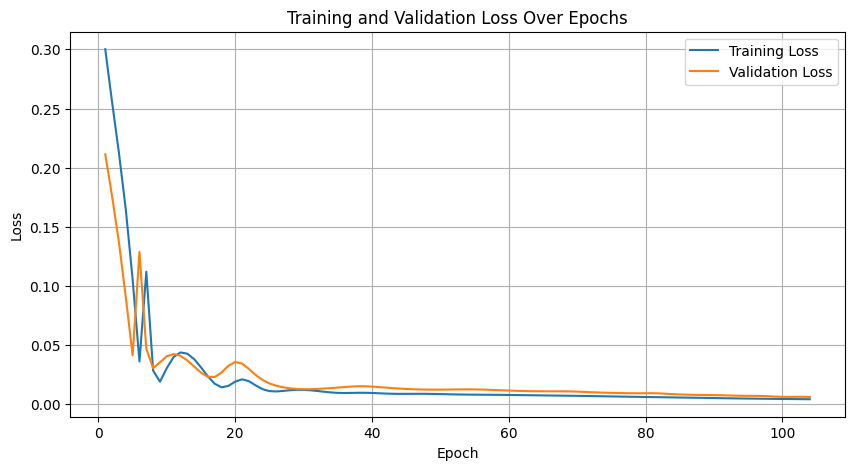

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'trained_lstm_model.pt')

Shape y_test: (1089, 4)
Thời gian bắt đầu test: 2025-02-14 16:00:00
Thời gian kết thúc test: 2025-04-01 00:00:00


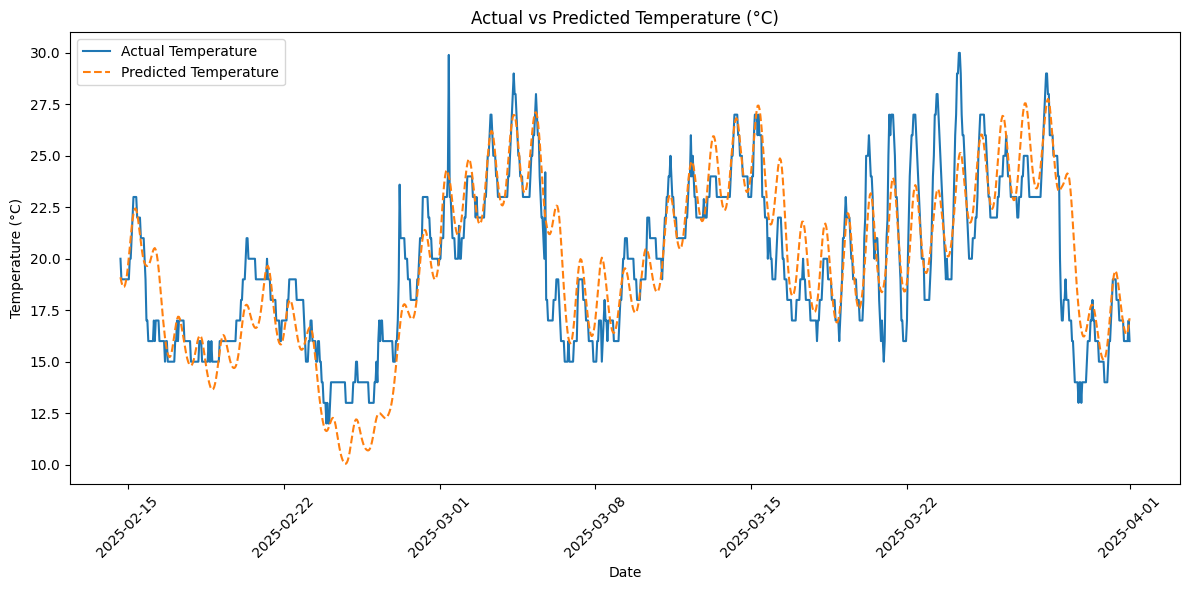

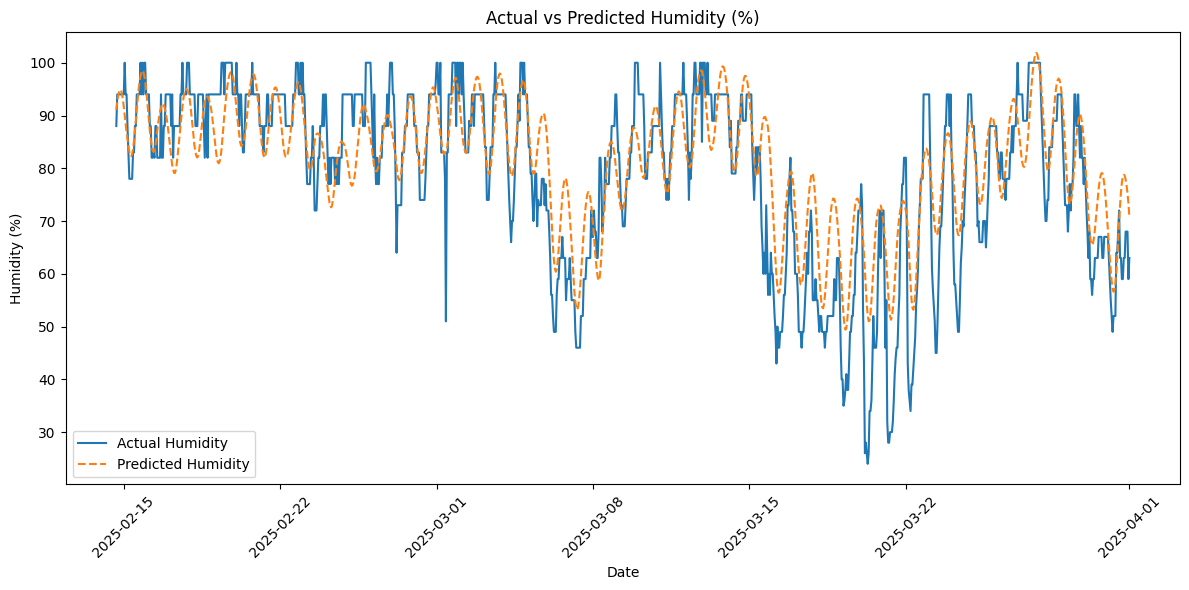

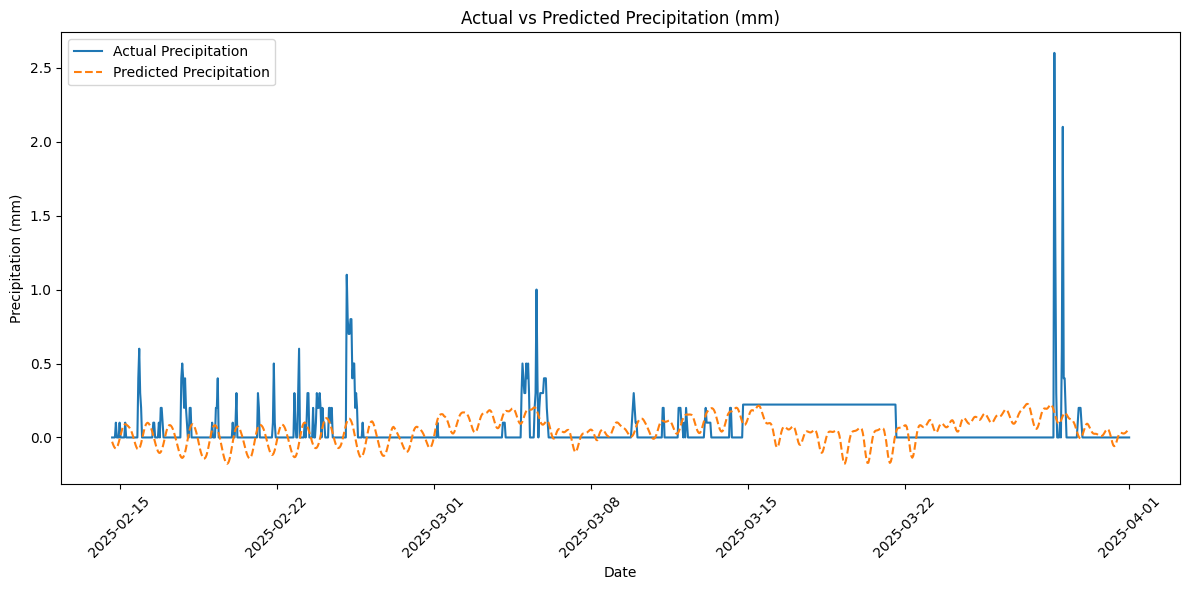

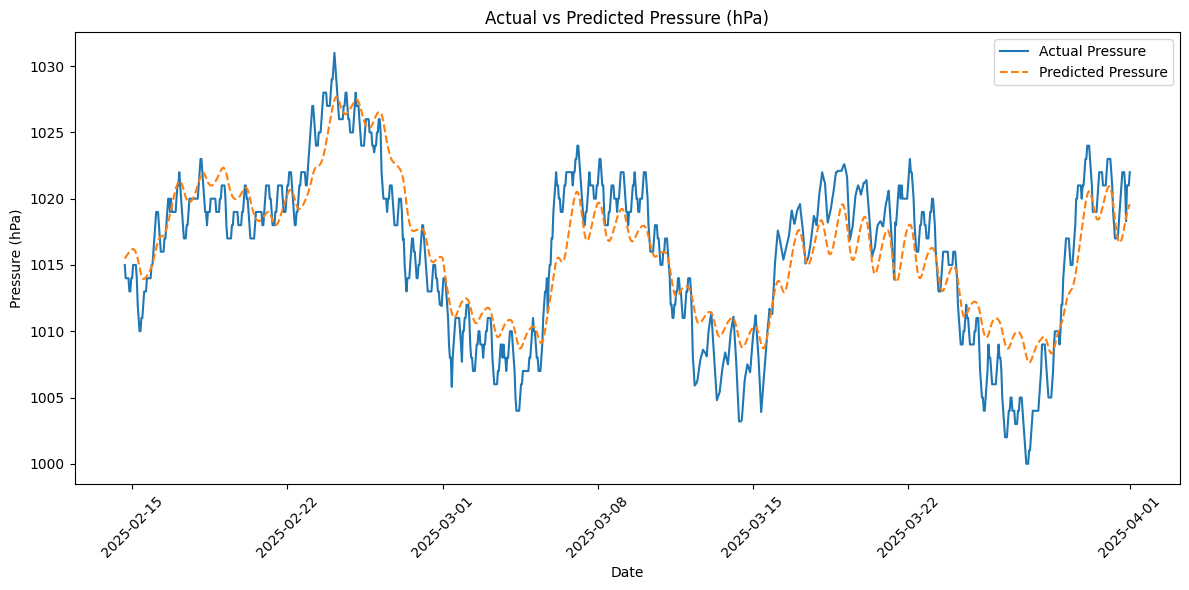

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import datetime, timedelta


# Testing the model
model = LSTMModel(input_size, hidden_size, output_size).to(device)
model.load_state_dict(torch.load('trained_lstm_model.pt'))
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs.squeeze(), y_test_tensor)
    y_pred = test_outputs.cpu().numpy()  # Move predictions to CPU before converting to numpy

# Generate date labels
dataset_start = pd.to_datetime('2024-01-01 00:00:00')
start_date = dataset_start + timedelta(hours= len(y_train) + len(y_val) + 48)
num_points = len(y_test)
date_range = pd.date_range(start=start_date, periods=num_points, freq='h')

variables = ['Temperature', 'Humidity', 'Precipitation', 'Pressure']
units = ['°C', '%', 'mm', 'hPa']

print("Shape y_test:", y_test.shape)
print("Thời gian bắt đầu test:", date_range[0])
print("Thời gian kết thúc test:", date_range[-1])


for i, (var, unit) in enumerate(zip(variables , units)):

    plt.figure(figsize=(12, 6))  # figure lớn cho từng biểu đồ
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # chỉ ngày, ẩn giờ
    plt.plot(date_range, scaler.inverse_transform(y_test)[:, i], label=f'Actual {var}')
    plt.plot(date_range, scaler.inverse_transform(y_pred)[:, i], label=f'Predicted {var}', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel(f"{var} ({unit})")
    plt.title(f'Actual vs Predicted {var} ({unit})')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    filename = f'{var.lower()}_comparison.png'
    plt.savefig(filename, dpi=300)
    plt.show()

In [ ]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_multivariate(y_test, y_pred, variable_names):
    mae_per_var = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
    mse_per_var = mean_squared_error(y_test, y_pred, multioutput='raw_values')
    rmse_per_var = np.sqrt(mse_per_var)

    mae_avg = mean_absolute_error(y_test, y_pred, multioutput='uniform_average')
    rmse_avg = np.sqrt(mean_squared_error(y_test, y_pred, multioutput='uniform_average'))

    # Tạo DataFrame báo cáo
    df_report = pd.DataFrame({
        'Variable': variable_names,
        'MAE': mae_per_var,
        'RMSE': rmse_per_var
    })

    # Tạo DataFrame cho dòng tổng trung bình
    avg_row = pd.DataFrame({
        'Variable': ['Average'],
        'MAE': [mae_avg],
        'RMSE': [rmse_avg]
    })

    # Dùng concat để nối DataFrame
    df_report = pd.concat([df_report, avg_row], ignore_index=True)

    print(df_report)

    # Styling bảng
    styled = (df_report.style
              .set_table_styles([{'selector': 'th', 'props': [('font-size', '16pt'), ('text-align', 'center')]},
                                 {'selector': 'td', 'props': [('font-size', '14pt')]}])
              .set_properties(**{'text-align': 'center'})
              .format({'MAE': '{:.4f}', 'RMSE': '{:.4f}'})
              .highlight_max(subset=['MAE', 'RMSE'], color='lightcoral')
              )

    display(styled)


# Gọi hàm:
evaluate_multivariate(y_test, y_pred, variables)


        Variable       MAE      RMSE
0    Temperature  0.044071  0.058640
1       Humidity  0.086369  0.114280
2  Precipitation  0.004050  0.006140
3       Pressure  0.047838  0.057667
4        Average  0.045582  0.070466


,Variable,MAE,RMSE
0,Temperature,0.0441,0.0586
1,Humidity,0.0864,0.1143
2,Precipitation,0.0041,0.0061
3,Pressure,0.0478,0.0577
4,Average,0.0456,0.0705


In [ ]:
with torch.no_grad():
    test_outputs = model(X_test_tensor[1].unsqueeze(0))
    y_pred_2 = test_outputs.cpu().numpy()  # Move predictions to CPU before converting to numpy

In [ ]:
y_pred_2

array([[ 0.3598074,  0.9056895, -0.0015365,  0.6244746]], dtype=float32)

In [ ]:
X_test_tensor.shape

torch.Size([1089, 48, 8])

In [ ]:
type(X_test_tensor[1])

torch.Tensor

In [ ]:
X_test_tensor[1].unsqueeze(0).shape

torch.Size([1, 48, 8])

In [ ]:
import torch

# Example tensor
a = torch.randn(sequence_length, input_size)

# Nest the tensor by adding a new dimension
b = a.unsqueeze(0)  # Adds a new dimension at the 0-th position

print(b.shape)  # Should print torch.Size([1, sequence_length, input_size])

torch.Size([1, 48, 8])
